In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa import seasonal
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

import missingno as msno

import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

## Load data from kaggle


In [2]:
import os
from pathlib import Path

_data_root = os.path.join("./../", 'data')
_data_root_raw = os.path.join(_data_root, 'raw')

In [3]:
isExist = os.path.exists(f"{_data_root}/store-sales-time-series-forecasting.zip")
if not isExist:
    !kaggle competitions download -c store-sales-time-series-forecasting -p {_data_root} --force

!unzip -o {_data_root}/"store-sales-time-series-forecasting.zip" -d {_data_root}
!mv {_data_root + "/*.csv"} {_data_root_raw}

Archive:  ./../data/store-sales-time-series-forecasting.zip
  inflating: ./../data/holidays_events.csv  
  inflating: ./../data/oil.csv       
  inflating: ./../data/sample_submission.csv  
  inflating: ./../data/stores.csv    
  inflating: ./../data/test.csv      
  inflating: ./../data/train.csv     
  inflating: ./../data/transactions.csv  


In [4]:
holidays_events = pd.read_csv(
    f"{_data_root_raw}/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events_start = holidays_events.copy()

store_sales = pd.read_csv(
    f"{_data_root_raw}/train.csv",
    usecols=['date', 'store_nbr', 'family', 'onpromotion', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['date', 'store_nbr', 'family']).sort_index()
store_sales_start = store_sales.copy()

average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
average_sales_start = average_sales.copy()

average_full_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
)
average_full_sales_start = average_full_sales.copy()

test_data = pd.read_csv(
    f"{_data_root_raw}/test.csv",
    usecols = ['date', 'store_nbr', 'family', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32'
    },
    parse_dates=['date'],
    date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
    infer_datetime_format=True,
    index_col=['date', 'store_nbr', 'family']
)

test_data_start = test_data.copy()

stores_df = pd.read_csv(f"{_data_root_raw}/stores.csv",
                        dtype={
                            'store_nbr': 'category',
                            'city': 'category',
                            'state': 'category',
                            'cluster': 'category'
                        }, usecols=['store_nbr', 'city', 'state', 'cluster', 'type']
                        )
stores_df_start = stores_df.copy()

In [5]:
store_sales.tail()

sales  onpromotion
date       store_nbr family                                              
2017-08-15 9         POULTRY                      438.132996            0
                     PREPARED FOODS               154.552994            1
                     PRODUCE                     2419.729004          148
                     SCHOOL AND OFFICE SUPPLIES   121.000000            8
                     SEAFOOD                       16.000000            0

In [6]:
test_data.tail()

onpromotion
date       store_nbr family                                 
2017-08-31 9         POULTRY                               1
                     PREPARED FOODS                        0
                     PRODUCE                               1
                     SCHOOL AND OFFICE SUPPLIES            9
                     SEAFOOD                               0

### Check for null data:

In [7]:
store_sales.isna().sum()

sales          0
onpromotion    0
dtype: int64

In [8]:
holidays_events.isna().sum()

type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

<AxesSubplot: >

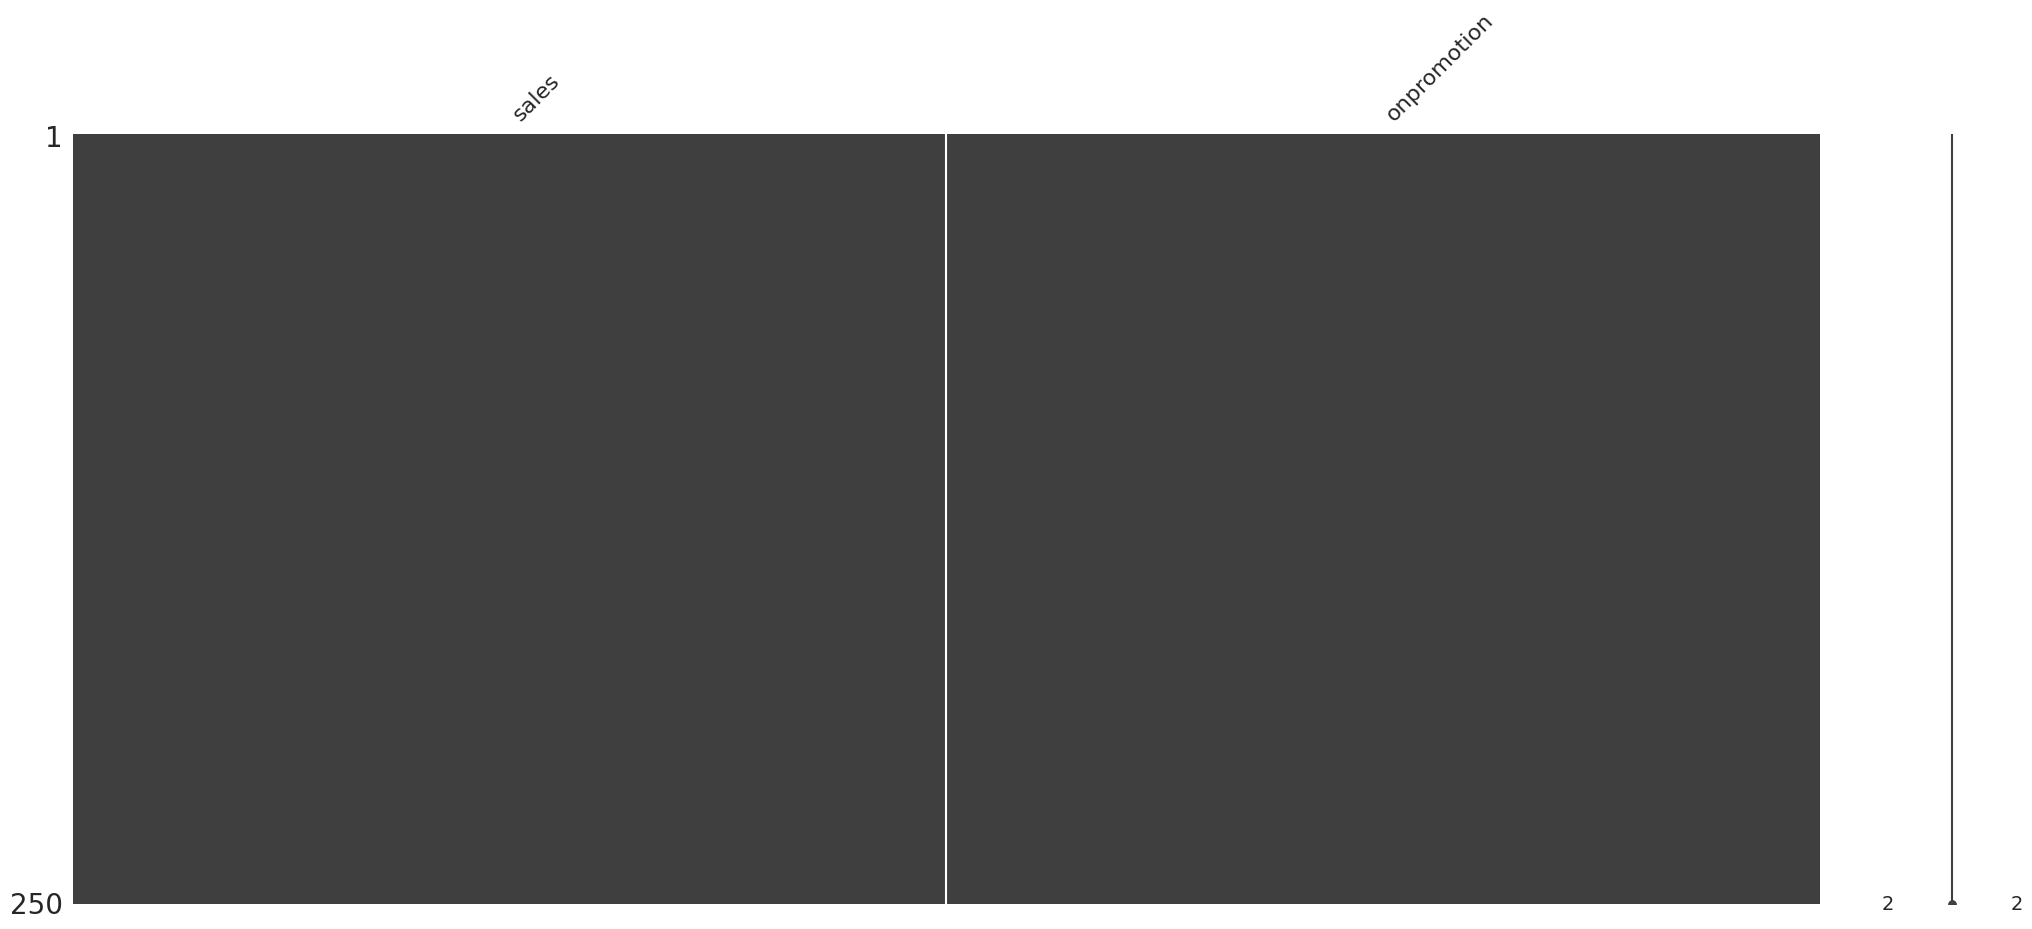

In [9]:
%matplotlib inline
msno.matrix(store_sales.sample(250))

<AxesSubplot: >

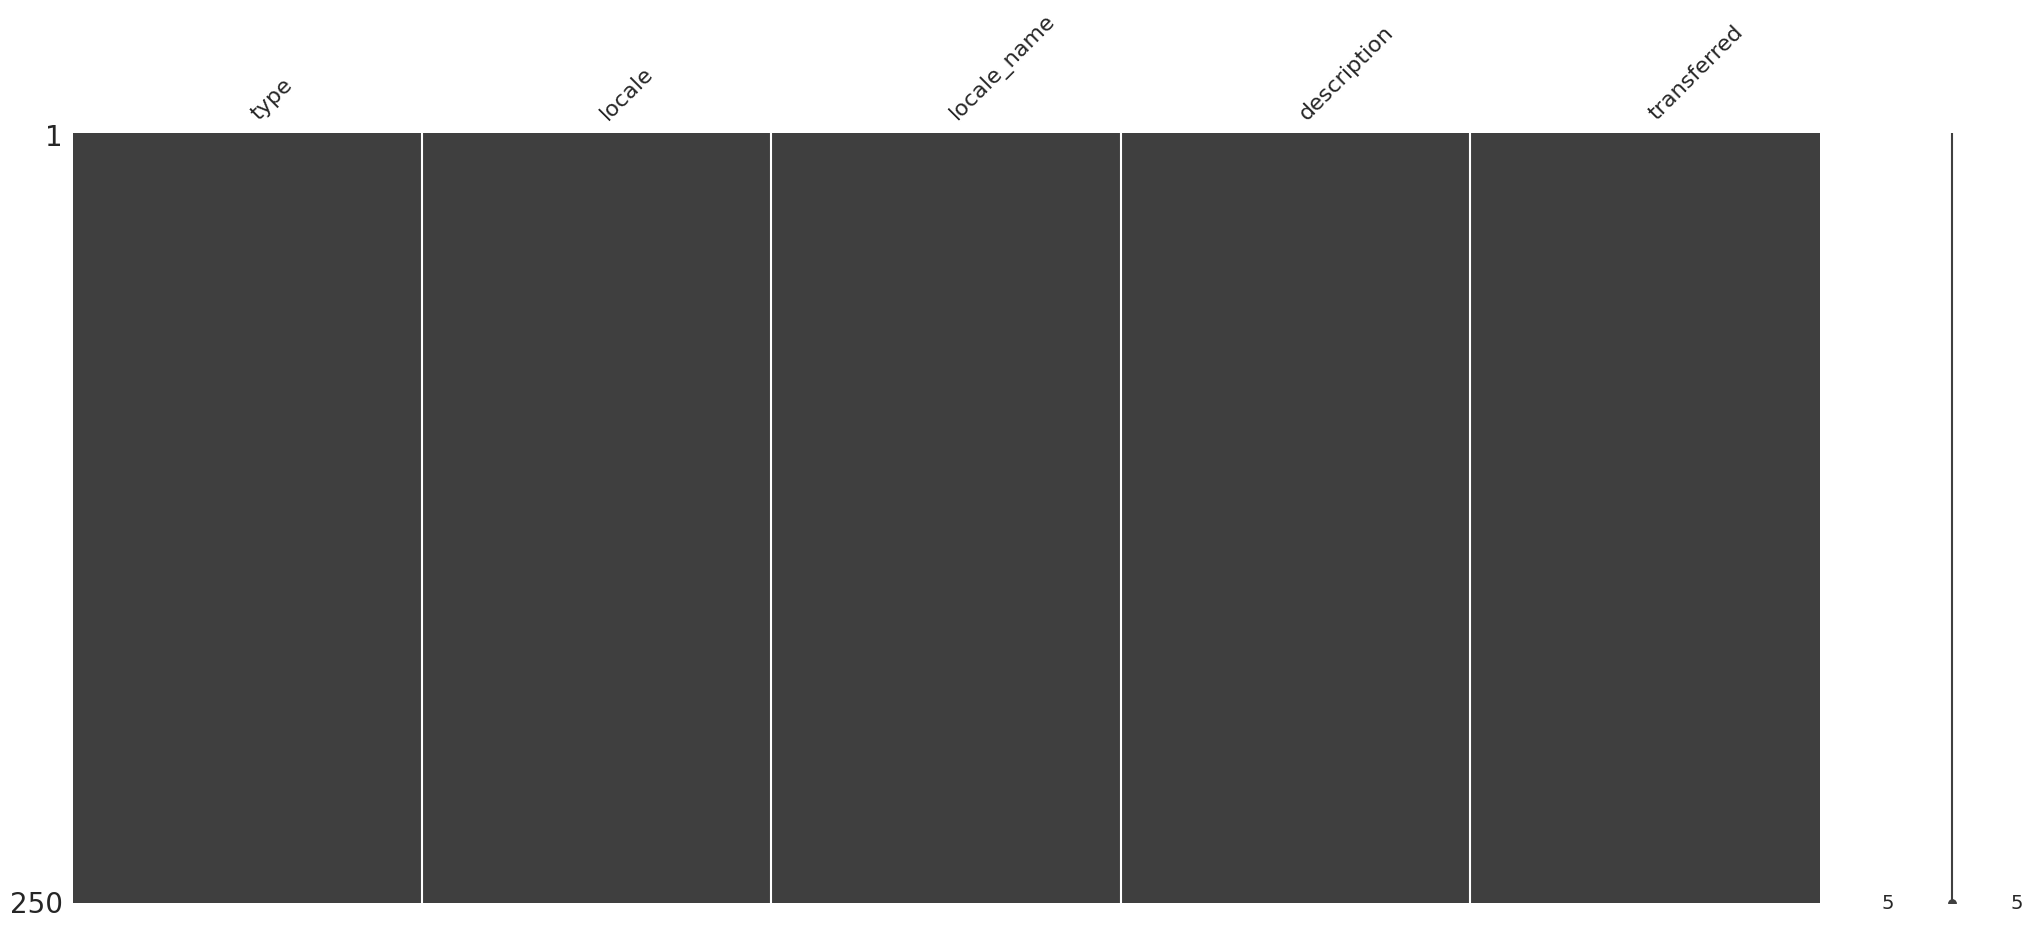

In [10]:
%matplotlib inline
msno.matrix(holidays_events.sample(250))

In [11]:
stores_df_start.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [12]:
family_2017_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc[:, ['sales', 'onpromotion']]
)


In [13]:
family_sales.index.names

FrozenList(['date'])

<AxesSubplot: xlabel='date'>

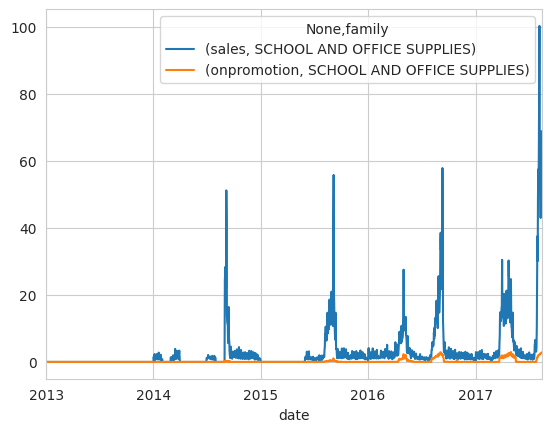

In [14]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
supply_sales.plot()


<AxesSubplot: xlabel='date'>

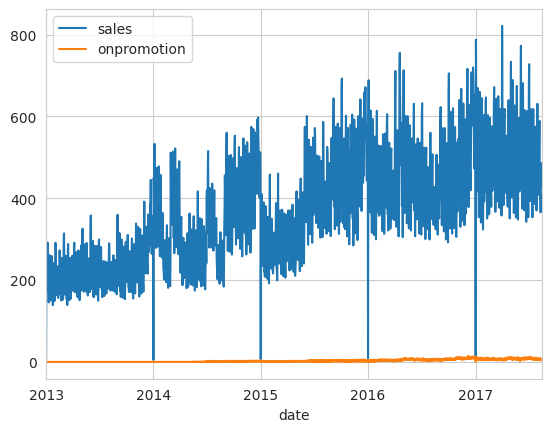

In [15]:
#supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
#supply_sales.plot()
average_full_sales.plot()

Check for seasonality

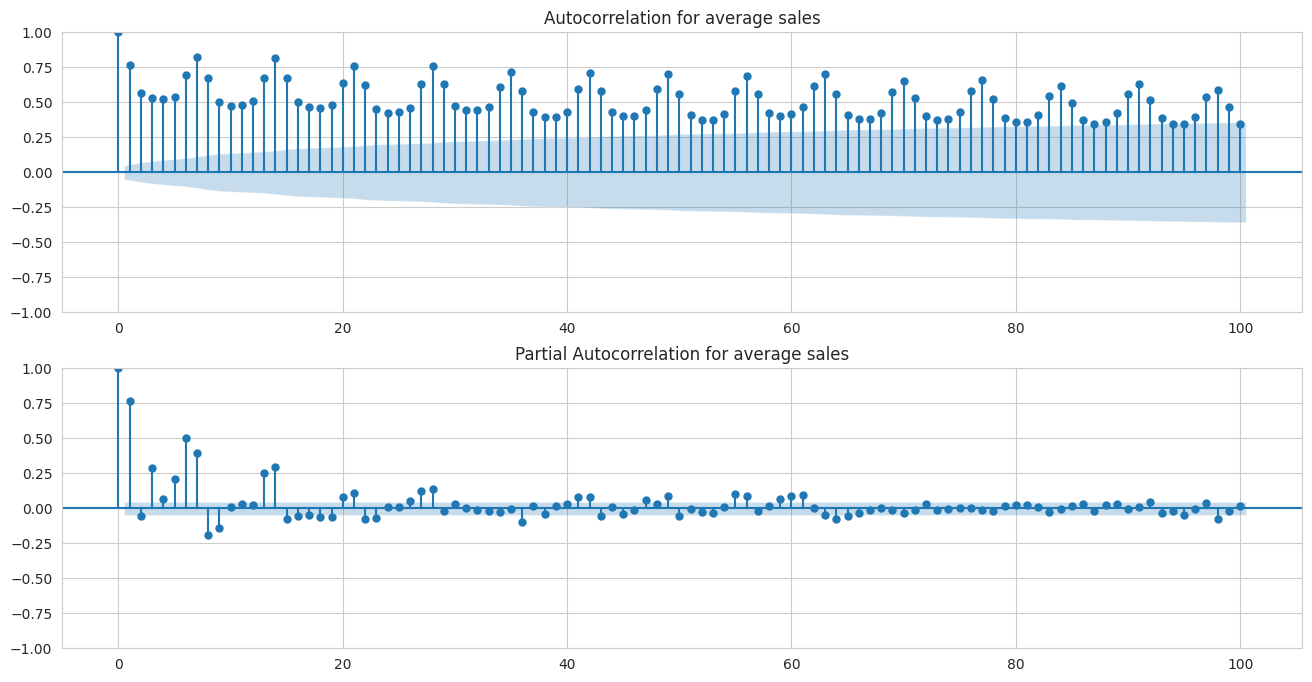

In [16]:
X = average_full_sales["sales"]
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=100, ax=ax1, title="Autocorrelation for average sales")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.values.squeeze(), lags=100, ax=ax2, title="Partial Autocorrelation for average sales")



We see that there is strong seasonality ( lag-1, lag-7 (weekly)
There also other correlations to lag-3, lag-5, lag-6, lag-8, atc and even lag-21

Try Determnistic process, to capture seasonality

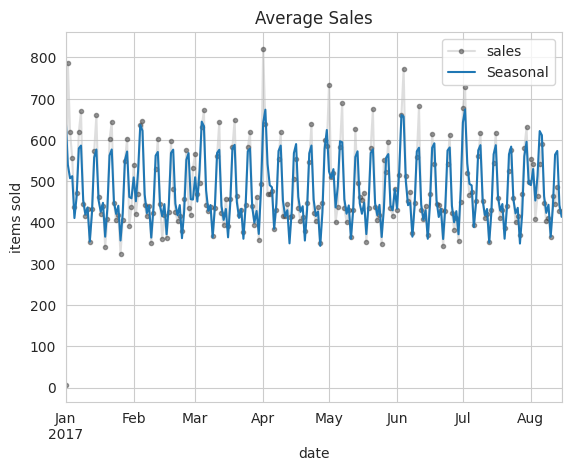

In [17]:
y = average_sales.copy()["sales"]

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()

model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name="y_pred"
)
#y_pred = pd.Series(mo)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# Plot
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Deseasonalized values:

Text(0.5, 1.0, 'Average Sales (deseasonalized) ')

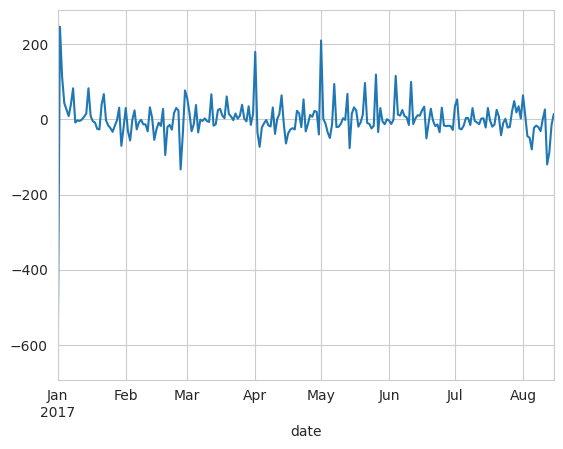

In [18]:
y_deseason = y - y_pred
y_deseason.name = 'average_sales_deseasoned'

y_deseason.plot()
ax.set_title("Average Sales (deseasonalized) ")

Check for aurocorrelation and lags for deseasonalized series:

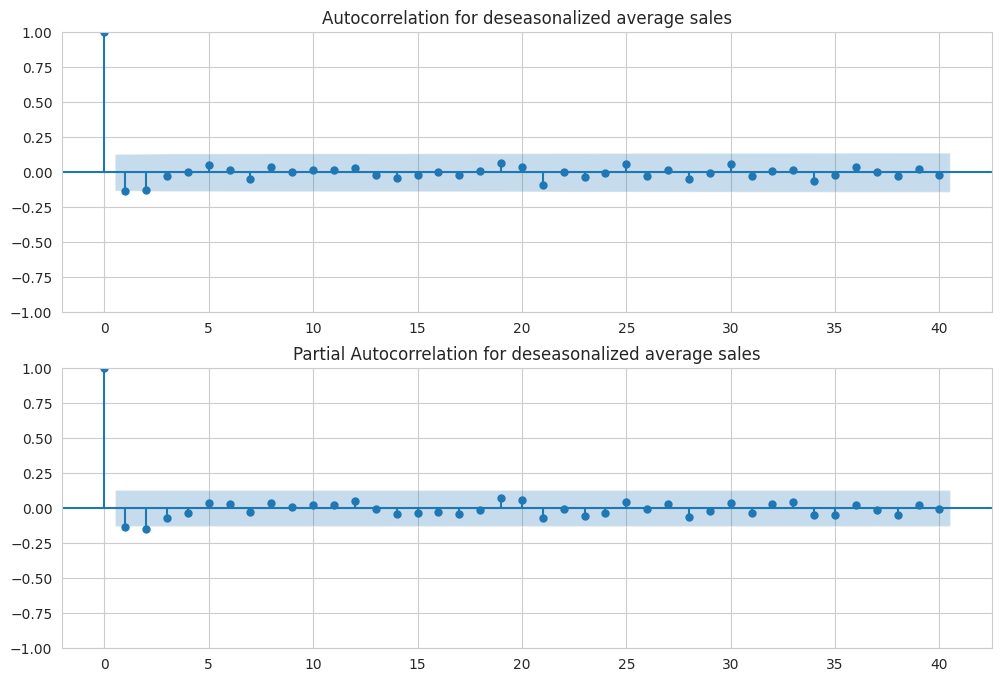

In [19]:
X = y_deseason
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40, ax=ax1, title="Autocorrelation for deseasonalized average sales")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.values.squeeze(), lags=40, ax=ax2, title="Partial Autocorrelation for deseasonalized average sales")

There is no significant correlation between lagged average_sales and current average_sales

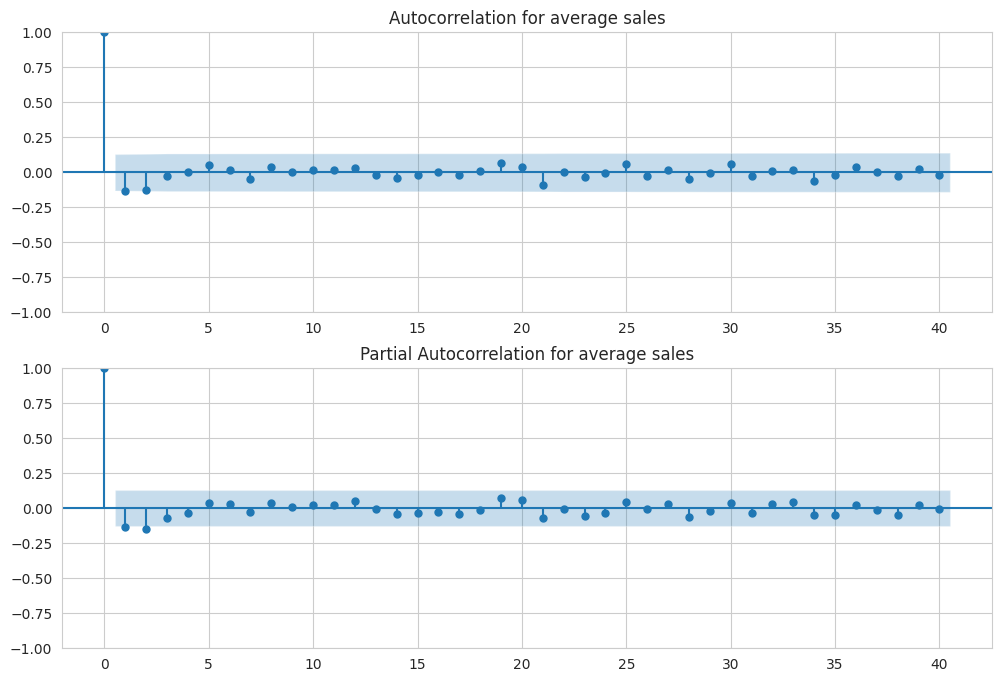

In [20]:
onpromotion = average_sales["onpromotion"]
# take only values where promotion is present

onpromotion = onpromotion.loc[onpromotion > 1]

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40, ax=ax1, title="Autocorrelation for average sales")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.values.squeeze(), lags=40, ax=ax2, title="Partial Autocorrelation for average sales")

To check if process is stationary, we can use AdFuller test

In [21]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(average_sales.sales.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']
print(f'adf_stat: {adf_stat}, p_val:{p_val}, crit_val_1: {crit_val_1}, crit_val_5: {crit_val_5}, crit_val_10: {crit_val_10} ')


adf_stat: -4.533949029498662, p_val:0.00017065458526097403, crit_val_1: -3.4615775784078466, crit_val_5: -2.875271898983725, crit_val_10: -2.5740891037735847 


### Code for plotting and making lags etc

In [22]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [23]:
def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)


def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None

    def fit(self, X_1, X_2, y, stack_cols=None):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=y.columns,
        )
        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack(stack_cols).squeeze()  # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        self.stack_cols = stack_cols

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack(self.stack_cols).squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)
        return y_pred.unstack(self.stack_cols)

def create_lags(df, target_col, lags=1, suffix='_lag', drop_target=True):
    for i in range(1, lags + 1) :
        df[f'{target_col}({suffix}{i})'] = df[target_col].shift(i)
    if drop_target:
        df = df.drop(columns=[target_col])
    return df

#### Multistep functions

In [24]:
def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)


def create_multistep_example(n, steps, lags, lead_time=1, start='2013'):
    ts = pd.Series(
        np.arange(n),
        index=pd.period_range(start=start, freq='A', periods=n, name='Year'),
        dtype=pd.Int8Dtype,
    )
    X = make_lags(ts, lags, lead_time)
    y = make_multistep_target(ts, steps, reverse=True)
    data = pd.concat({'Targets': y, 'Features': X}, axis=1)
    data = data.style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
        .set_properties(['Features'], **{'background-color': 'Lavender'})
    return data


def load_multistep_data():
    df1 = create_multistep_example(10, steps=1, lags=3, lead_time=1)
    df2 = create_multistep_example(10, steps=3, lags=4, lead_time=2)
    df3 = create_multistep_example(10, steps=3, lags=4, lead_time=1)
    return [df1, df2, df3]


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

#### stores_df analyze

In [25]:
stores_df_start.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [26]:
city_store_counts = stores_df_start["city"].value_counts().to_dict()

In [27]:
stores_df_start["type"].value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

#### Holidays


In [28]:
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Many Nan values - normal workday dates were not filled not holiday csv

### Functions to create features

#### Create features for stores

In [29]:
def make_stores_df_features(stores_df: pd.DataFrame):
    city_store_counts = stores_df["city"].value_counts().to_dict()
    stores_df['is_unique_in_city'] =  stores_df["city"].apply(lambda city: 1 if city_store_counts.get(city) == 1 else 0 )
    stores_df = stores_df.rename(columns={'type' : 'store_type'})
    stores_df = stores_df.set_index(['store_nbr']).sort_index()
    return stores_df

In [30]:
stores_df_features = stores_df_start.copy()
stores_df_features = make_stores_df_features(stores_df_features)
print(stores_df_features.columns)
print(stores_df_features.dtypes)
stores_df_features.head()

Index(['city', 'state', 'store_type', 'cluster', 'is_unique_in_city'], dtype='object')
city                 category
state                category
store_type             object
cluster              category
is_unique_in_city       int64
dtype: object


,city,state,store_type,cluster,is_unique_in_city
store_nbr,,,,,
1,Quito,Pichincha,D,13,0
10,Quito,Pichincha,C,15,0
11,Cayambe,Pichincha,B,6,1
12,Latacunga,Cotopaxi,C,15,0
13,Latacunga,Cotopaxi,C,15,0


#### Create features for holidays calendar

In [31]:
def create_calendar_df(holidays_events_df: pd.DataFrame = holidays_events):
    days_range = pd.Series(pd.date_range('2013-01-01', '2017-08-31').to_period('D'), name='date')

    calendar_df = pd.DataFrame(index=days_range)

    # merge holidays with calendar df
    calendar_df = calendar_df.merge(holidays_events_df, how='left', on=['date'])
    calendar_df = calendar_df.sort_index()

    calendar_df["type"].fillna("Work Day", inplace = True)
    calendar_df["locale"].fillna("National", inplace = True)
    calendar_df["locale_name"].fillna("Ecuador", inplace = True)
    #calendar_df["description"].fillna("Some Holiday", inplace = True)
    calendar_df["transferred"].fillna(False, inplace = True)
    return calendar_df

def make_calendar_features(calendar_df: pd.DataFrame):
    # set workday feature as all non-holiday
    calendar_df['work_day'] = True
    calendar_df.loc[calendar_df.type == 'Bridge', 'work_day'] = False
    calendar_df.loc[calendar_df.type == 'Transfer', 'work_day'] = False
    calendar_df.loc[(calendar_df.type == 'Additional') & (calendar_df.transferred == False), 'work_day'] = False
    calendar_df.loc[(calendar_df.type == 'Holiday') & (calendar_df.transferred == False), 'work_day'] = False

    calendar_df['isevent'] = False
    calendar_df.loc[calendar_df.type == 'Event', 'isevent'] = True

    calendar_df = pd.get_dummies(calendar_df, columns=['type'], drop_first=True)
    calendar_df = pd.get_dummies(calendar_df, columns=['locale'], drop_first=True)

    calendar_df.drop(columns=['locale_name', 'transferred'], inplace = True)

    # Reduce duplicate rows
    calendar_df = calendar_df.groupby('date').agg(lambda x: np.bitwise_or.reduce(x.values))

    return calendar_df

def add_calendar_features(calendar_df: pd.DataFrame):
    calendar_df['year'] = calendar_df.index.get_level_values('date').year.astype('int')
    calendar_df['quarter'] = calendar_df.index.get_level_values('date').quarter.astype('int')
    calendar_df['day_of_year'] = calendar_df.index.get_level_values('date').dayofyear.astype('int')
    calendar_df['week_of_year'] = calendar_df.index.get_level_values('date').weekofyear.astype('int')
    calendar_df['day_of_week'] = calendar_df.index.get_level_values('date').dayofweek.astype('int')
    calendar_df['is_weekend'] = calendar_df.index.get_level_values('date').dayofweek.isin((5, 6))
    calendar_df['begin_year'] = calendar_df.index.get_level_values('date').dayofyear == 1
    calendar_df['school'] = calendar_df.index.get_level_values('date').month.isin((4, 5, 8, 9)).astype('bool')

    return calendar_df


In [32]:
calendar_df_features = create_calendar_df(holidays_events_df=holidays_events)
calendar_df_features = make_calendar_features(calendar_df_features)
calendar_df_features = add_calendar_features(calendar_df_features)
print(calendar_df_features.index.names)
calendar_df_features.head(20)

['date']


,work_day,isevent,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,year,quarter,day_of_year,week_of_year,day_of_week,is_weekend,begin_year,school
date,,,,,,,,,,,,,,,,,
2013-01-01,False,False,0,0,1,0,0,1,0,2013,1,1,1,1,False,True,False
2013-01-02,True,False,0,0,0,0,1,1,0,2013,1,2,1,2,False,False,False
2013-01-03,True,False,0,0,0,0,1,1,0,2013,1,3,1,3,False,False,False
2013-01-04,True,False,0,0,0,0,1,1,0,2013,1,4,1,4,False,False,False
2013-01-05,True,False,0,0,0,0,1,1,0,2013,1,5,1,5,True,False,False
2013-01-06,True,False,0,0,0,0,1,1,0,2013,1,6,1,6,True,False,False
2013-01-07,True,False,0,0,0,0,1,1,0,2013,1,7,2,0,False,False,False
2013-01-08,True,False,0,0,0,0,1,1,0,2013,1,8,2,1,False,False,False
2013-01-09,True,False,0,0,0,0,1,1,0,2013,1,9,2,2,False,False,False


#### Other feature engineering functions

In [33]:
def make_dummies(feature_df: pd.DataFrame):
    feature_df = pd.get_dummies(feature_df, columns=['year'], drop_first=True)
    feature_df = pd.get_dummies(feature_df, columns=['quarter'], drop_first=True)
    feature_df = pd.get_dummies(feature_df, columns=['day_of_week'], drop_first=True)

    return feature_df

def make_onpromotion_rolling_features(feature_df: pd.DataFrame):
    feature_df['onpromotion_week_avg'] = feature_df['onpromotion'].rolling(7).mean()
    feature_df['onpromotion_biweek_avg'] = feature_df['onpromotion'].rolling(14).mean()
    feature_df['onpromotion_1_month_avg'] = feature_df['onpromotion'].rolling(30).mean()
    feature_df['onpromotion_2_month_avg'] = feature_df['onpromotion'].rolling(60).mean()

    return feature_df


def drop_features(feature_df: pd.DataFrame):
    feature_df.drop(columns=['city', 'cluster', 'state', 'store_type'], inplace=True)
    return feature_df



##### Merge train and test data before feature engineering

##### Merge dataframes: train_test + stores + holidays functions

In [46]:
def create_final_feature_df(train_df, test_df):
    final_feature_df = train_df.copy()
    test_df_copy = test_df.copy()

    test_df_copy["sales"] = np.NaN

    final_feature_df = pd.concat([final_feature_df, test_df_copy], axis=0)
    print(f'index_columns: {final_feature_df.index.names}')
    return final_feature_df


def merge_feature_df(feature_df, stores_df_features=None, calendar_df_features=None):
    # merge to store features
    if stores_df_features is not None:
        feature_df = feature_df.merge(stores_df_features, how='left', left_index=True, right_index=True)
        feature_df.drop(feature_df.filter(regex='_y$').columns, axis=1, inplace=True)

    # merge to holidays
    if calendar_df_features is not None:
        feature_df = feature_df.merge(calendar_df_features, how='left', left_index=True, right_index=True, suffixes=('', '_y'))
        feature_df.drop(feature_df.filter(regex='_y$').columns, axis=1, inplace=True) # Drop common columns after merge

    return feature_df

final_feature_df = create_final_feature_df(train_df=store_sales_start, test_df=test_data_start)
final_feature_df_unstacked = final_feature_df.unstack(['store_nbr', 'family'])
y_unstacked = final_feature_df_unstacked.copy()
print(final_feature_df_unstacked.columns.names)
final_feature_df_unstacked.sample(5)

index_columns: ['date', 'store_nbr', 'family']
[None, 'store_nbr', 'family']


sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2016-01-03        1.0       0.0    2.0    1048.0   0.0   138.274994   
2014-12-06        5.0       0.0    6.0    1737.0   0.0   268.717010   
2016-02-17        4.0       0.0    4.0    2313.0   0.0   435.493011   
2014-01-22        5.0       0.0    3.0    2168.0   0.0   424.251007   
2015-10-02        4.0       0.0    4.0    2286.0   0.0   413.216003   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2016-01-03         5.0    293.0  382.0   59.737000  ...           0     0   
2014-12-06        12.0    553.0  702.0  103.088997  ...           0     0   
2016-02-17        24.0    783.0  944.0  130.272003  ...           0     0   
2014-01-22        17.0    904.0  743.0  119.581001  ...           0     0   
2015-10-02        22.0    828.0  844.0  202.427994  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2016-01-03             3            0                       0       0   
2014-12-06             0            0                       0       1   
2016-02-17             1            0                       0       0   
2014-01-22             0            0                       0       0   
2015-10-02             2            0                       0      18   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2016-01-03              0       0                          0       0  
2014-12-06              0       0                          0       0  
2016-02-17             10       0                          0       0  
2014-01-22              0       0                          0       0  
2015-10-02              1       0                          0       0  

[5 rows x 3564 columns]

In [35]:
final_feature_df.dtypes

sales          float32
onpromotion     uint32
dtype: object

Add Time-dependend features, fourier terms and seasonal terms


In [47]:
def make_dp_fourier_features(feature_df): # feature_df is unstacked


    fourierA = CalendarFourier(freq='A', order=5) # annual
    fourierM = CalendarFourier(freq='M', order=2) # monthly
    fourierW = CalendarFourier(freq='W', order=3) # weekly

    dp = DeterministicProcess(index=feature_df.index.get_level_values('date'),
                              order=1,
                              seasonal=True,
                              constant=False,
                              additional_terms=[fourierA, fourierM, fourierW],
                              drop=True
                              )

    dp_df = dp.in_sample()
    #feature_df = pd.concat([feature_df.reset_index(level=['store_nbr', 'family']), dp_df], axis=1)
    #feature_df = feature_df.set_index(['store_nbr', 'family'], append=True)
    return dp_df

final_feature_df_unstacked = make_dp_fourier_features(final_feature_df_unstacked)
final_feature_df_unstacked

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2013-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.201299,0.979530,0.394356,0.918958,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2013-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.394356,0.918958,0.724793,0.688967,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2013-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.571268,0.820763,0.937752,0.347305,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2013-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.724793,0.688967,0.998717,-0.050649,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,1696.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.816538,-0.577292,...,-0.848644,0.528964,-0.897805,-0.440394,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2017-08-28,1697.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.826354,-0.563151,...,-0.724793,0.688967,-0.998717,-0.050649,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-08-29,1698.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.835925,-0.548843,...,-0.571268,0.820763,-0.937752,0.347305,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969


In [48]:

#final_feature_df = merge_feature_df(final_feature_df, stores_df_features, calendar_df_features)
#final_feature_df = create_datetime_features(final_feature_df)
#final_feature_df = make_dummies(final_feature_df)
#final_feature_df = make_onpromotion_rolling_features(final_feature_df)
#final_feature_df = drop_features(final_feature_df)

final_feature_df_unstacked = merge_feature_df(feature_df=final_feature_df_unstacked, stores_df_features=None, calendar_df_features=calendar_df_features)

#feature_df = drop_features(feature_df)
final_feature_df_unstacked.sample(10)

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,locale_National,locale_Regional,year,quarter,day_of_year,week_of_year,day_of_week,is_weekend,begin_year,school
date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,1092.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.017213,0.999852,...,1,0,2015,4,365,53,3,False,False,False
2015-04-23,841.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.936881,-0.349647,...,1,0,2015,2,113,17,3,False,False,True
2017-06-23,1631.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.162807,-0.986658,...,0,0,2017,2,174,25,4,False,False,False
2013-02-17,48.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.723644,0.690173,...,1,0,2013,1,48,7,6,True,False,False
2013-05-30,150.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.545240,-0.838280,...,1,0,2013,2,150,22,3,False,False,True
2013-04-09,99.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993257,-0.115935,...,1,0,2013,2,99,15,1,False,False,True
2016-06-14,1258.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.304115,-0.952635,...,1,0,2016,2,166,24,1,False,False,False
2016-04-07,1190.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.995546,-0.094279,...,1,0,2016,2,98,14,3,False,False,True
2015-06-26,905.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.111659,-0.993747,...,1,0,2015,2,177,26,4,False,False,False


In [49]:
final_feature_df_unstacked.isna().sum()

trend                0
s(1,7)               0
s(2,7)               0
s(3,7)               0
s(4,7)               0
s(5,7)               0
s(6,7)               0
s(7,7)               0
sin(1,freq=A-DEC)    0
cos(1,freq=A-DEC)    0
sin(2,freq=A-DEC)    0
cos(2,freq=A-DEC)    0
sin(3,freq=A-DEC)    0
cos(3,freq=A-DEC)    0
sin(4,freq=A-DEC)    0
cos(4,freq=A-DEC)    0
sin(5,freq=A-DEC)    0
cos(5,freq=A-DEC)    0
sin(1,freq=M)        0
cos(1,freq=M)        0
sin(2,freq=M)        0
cos(2,freq=M)        0
sin(1,freq=W-SUN)    0
cos(1,freq=W-SUN)    0
sin(2,freq=W-SUN)    0
cos(2,freq=W-SUN)    0
sin(3,freq=W-SUN)    0
cos(3,freq=W-SUN)    0
work_day             0
isevent              0
type_Bridge          0
type_Event           0
type_Holiday         0
type_Transfer        0
type_Work Day        0
locale_National      0
locale_Regional      0
year                 0
quarter              0
day_of_year          0
week_of_year         0
day_of_week          0
is_weekend           0
begin_year 

In [39]:
display(y)

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   
...               ...       ...    ...       ...   ...          ...   
2017-08-27        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-28        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-29        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-30        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-31        NaN       NaN    NaN       NaN   NaN          NaN   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...           0     0   
2013-01-02         0.0   1060.0  579.0  164.069000  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582001  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.410995  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.612999  ...           0     0   
...                ...      ...    ...         ...  ...         ...   ...   
2017-08-27         NaN      NaN    NaN         NaN  ...           0     0   
2017-08-28         NaN      NaN    NaN         NaN  ...           0     0   
2017-08-29         NaN      NaN    NaN         NaN  ...           0     0   
2017-08-30         NaN      NaN    NaN         NaN  ...           0     0   
2017-08-31         NaN      NaN    NaN         NaN  ...           0    20   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0   
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   
...                  ...          ...                     ...     ...   
2017-08-27            14            0                       0       0   
2017-08-28            11            0                       0       0   
2017-08-29            12            0                       0       0   
2017-08-30            12            0                       0       0   
2017-08-31            14            0                       0       1   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  
...                   ...     ...                        ..

In [50]:
def split_data_train_test(df, train_df_start_date, train_df_end_date, test_df_start_date, test_df_end_date):
    df_train = df.loc[train_df_start_date: train_df_end_date]
    df_test = df.loc[test_df_start_date: test_df_end_date]
    return df_train, df_test

def unstack_transformation(X, y, group_by='date', target='sales', levels=['store_nbr', 'family']):
    df = X.copy()
    df[target] = y
    y = df.loc[:, target].unstack(levels)
    X = df.drop(columns=[target]).groupby(by=group_by).first()
    return X, y


In [41]:
final_feature_df_unstacked

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,locale_National,locale_Regional,year,quarter,day_of_year,week_of_year,day_of_week,is_weekend,begin_year,school
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,1,0,2013,1,1,1,1,False,True,False
2013-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,1,0,2013,1,2,1,2,False,False,False
2013-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,1,0,2013,1,3,1,3,False,False,False
2013-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,1,0,2013,1,4,1,4,False,False,False
2013-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,1,0,2013,1,5,1,5,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,1696.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.816538,-0.577292,...,1,0,2017,3,239,34,6,True,False,True
2017-08-28,1697.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.826354,-0.563151,...,1,0,2017,3,240,35,0,False,False,True
2017-08-29,1698.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.835925,-0.548843,...,1,0,2017,3,241,35,1,False,False,True


In [55]:
def separate_X_and_y(df, target='sales'):
    y = df[target].values
    X = df.drop(columns=target)
    return X, y

X_train, X_test = split_data_train_test(final_feature_df_unstacked, train_df_start_date='2013-01-01', train_df_end_date='2017-08-15',
                                        test_df_start_date='2017-08-16', test_df_end_date='2017-08-31')
y_train, _ = split_data_train_test(y_unstacked, train_df_start_date='2013-01-01', train_df_end_date='2017-08-15',
                                        test_df_start_date='2017-08-16', test_df_end_date='2017-08-31')

X, y = X_train.copy(), y_train.copy()


model = LinearRegression(fit_intercept=False, normalize=True)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
#print(y_pred.columns)
#print(y_pred.index.names)
y_pred

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2013-01-01  -1.485117       0.0 -0.129162  -571.069692 -0.213277   -71.540500   
2013-01-02   2.251184       0.0  1.901994  1421.889492 -0.095273   376.196378   
2013-01-03   1.657832       0.0  1.997698  1173.754173 -0.167449   309.309214   
2013-01-04   2.736186       0.0  1.928179  1413.723684 -0.012309   326.748974   
2013-01-05   2.684539       0.0  2.150115  1451.500877 -0.068112   323.934872   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   4.193168       0.0  1.660478  1456.511530  0.222565   197.184586   
2017-08-12   4.743504       0.0  3.782291  2481.255313  0.434322   385.866018   
2017-08-13   2.538003       0.0  2.207395  1364.280672  0.407106   178.841841   
2017-08-14   4.085597       0.0  3.677933  2294.751488  0.435618   393.695007   
2017-08-15   4.981931       0.0  3.452621  2281.328145  0.465457   351.735849   

                                                            ... onpromotion  \
store_nbr                                                   ...           9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                        ...               
2013-01-01   -9.568995  -36.431686 -184.763035  -20.110239  ...   -0.010342   
2013-01-02   -0.874177  954.595637  634.654034  131.991290  ...   -0.005161   
2013-01-03   -1.888785  783.190101  480.667857  107.005504  ...   -0.013721   
2013-01-04    2.387583  849.564334  568.086780  141.414476  ...   -0.022148   
2013-01-05   -0.408586  719.447545  597.192610  128.046004  ...   -0.019398   
...                ...         ...         ...         ...  ...         ...   
2017-08-11   10.109547  352.924258  454.404301   79.735679  ...   -0.010645   
2017-08-12   18.571099  588.482079  798.599021  139.111523  ...    0.019107   
2017-08-13    9.320548  247.830071  374.023109   65.481212  ...    0.028151   
2017-08-14   17.623598  663.579114  728.635595  141.694148  ...    0.018378   
2017-08-15   11.450193  650.218083  684.425366  124.211927  ...   -0.004715   

                                                                         \
store_nbr                                                                 
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2013-01-01 -5.562163     -4.272157    -0.092532               -0.039900   
2013-01-02 -2.869431     -3.316192    -0.038863               -0.037395   
2013-01-03  8.811140     -3.535715    -0.068337               -0.079365   
2013-01-04 -1.813966     -4.017759    -0.075885               -0.063406   
2013-01-05 -1.356472     -3.485644    -0.072605               -0.069849   
...              ...           ...          ...                     ...   
2017-08-11  3.212379     14.962357    -0.025160               -0.021067   
2017-08-12  3.085969     13.057642     0.061034                0.106238   
2017-08-13  1.770242     13.352308     0.056167                0.124465   
2017-08-14 -2.136599     13.027984     0.027632                0.053368   
2017-08-15  0.392169     12.861590    -0.056223                0.037844   

                                                                             \
store_nbr                                                                     
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2013-01-01  -3.838326      -2.349883   44.108946                  -0.364190   
2013-01-02   0.213262       1.956226  -11.747937                  -0.569176   
2013-01-03  -0

In [59]:
y_long = y.stack(['store_nbr', 'family'])
y_long.head()


onpromotion  sales
date       store_nbr family                        
2013-01-01 1         AUTOMOTIVE            0    0.0
                     BABY CARE             0    0.0
                     BEAUTY                0    0.0
                     BEVERAGES             0    0.0
                     BOOKS                 0    0.0

In [60]:
y_pred_long = y_pred.stack(['store_nbr', 'family'])
y_pred_long.head()

onpromotion       sales
date       store_nbr family                             
2013-01-01 1         AUTOMOTIVE    -0.005380   -1.485117
                     BABY CARE      0.000000    0.000000
                     BEAUTY        -0.136437   -0.129162
                     BEVERAGES    -12.348873 -571.069692
                     BOOKS          0.000000   -0.213277

In [54]:
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns).clip(0.)
y_pred_test = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns).clip(0.)



y_long = y.stack(['store_nbr', 'family'])
y_pred_long = y_pred.stack(['store_nbr', 'family'])
y_long['pred'] = y_pred_long.values

# Errors by each family category
print(y_long.groupby('family').apply(lambda r : np.sqrt(np.sqrt(mean_squared_log_error(r['sales'], r['pred'])))))
# Overal error
print('RMSLE : ', np.sqrt(np.sqrt(mean_squared_log_error(y_long['sales'], y_long['pred']))))


ValueError: Expected a 1D array, got an array with shape (3000888, 2)

### Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = store_sales
y = store_sales.sales

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [ ]:
#X = store_sales.copy()
holidays_events.isna()

